In [7]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def load_experiment_data(experiments_dir="experiments"):
    """Load all game data from JSON files"""
    # Load individual game files
    game_files = glob(os.path.join(experiments_dir, "game_*.json"))
    
    # Load summary files for additional context
    summary_files = glob(os.path.join(experiments_dir, "experiment_summary_*.json"))
    
    games_data = []
    
    # Load individual game results
    for file_path in game_files:
        try:
            with open(file_path, 'r') as f:
                game_data = json.load(f)
                if 'error' not in game_data:  # Only include successful games
                    games_data.append(game_data)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Load summary files for additional context
    summary_data = []
    for file_path in summary_files:
        try:
            with open(file_path, 'r') as f:
                summary = json.load(f)
                summary_data.append(summary)
        except Exception as e:
            print(f"Error loading summary {file_path}: {e}")
    
    return games_data, summary_data

def analyze_game_outcomes(games_data):
    """Analyze game outcomes and determine if player won"""
    results = []
    
    for game in games_data:
        # Determine if player won based on rewards
        player_won = False
        if 'rewards' in game and game['rewards']:
            # In 20 Questions, player wins if they get positive reward (successful guess)
            player_reward = game['rewards']["0"]  # Player 0's reward
            player_won = player_reward > 0
        
        # Extract final guess if available
        final_guess = None
        if 'observations' in game:
            for obs in reversed(game['observations']):
                if obs['player'] == 0 and '[' in obs['message'] and ']' in obs['message']:
                    final_guess = obs['message']
                    break
        
        result = {
            'game_id': game.get('game_id'),
            'model_name': game.get('model_name'),
            'agent_type': game.get('agent_type'),
            'player_won': player_won,
            'turn_count': game.get('turn_count', 0),
            'game_duration': game.get('game_duration', 0),
            'ground_truth_word': game.get('ground_truth_word'),
            'ground_truth_theme': game.get('ground_truth_theme'),
            'final_guess': final_guess,
            'timestamp': game.get('timestamp')
        }
        results.append(result)
    
    return pd.DataFrame(results)

# Load the data
print("Loading experiment data...")
games_data, summary_data = load_experiment_data()

print(f"Loaded {len(games_data)} games and {len(summary_data)} summaries")

if games_data:
    # Convert to DataFrame for analysis
    df = analyze_game_outcomes(games_data)
    print(f"Analyzed {len(df)} games successfully")
    
    # Show basic info
    print(f"\nModels tested: {df['model_name'].unique()}")
    print(f"Agent types tested: {df['agent_type'].unique()}")
    print(f"Overall win rate: {df['player_won'].mean():.1%}")
else:
    print("No game data found. Make sure to run experiments first!")

Loading experiment data...
Loaded 8 games and 0 summaries
Analyzed 8 games successfully

Models tested: ['openai/gpt-4o']
Agent types tested: ['EIG']
Overall win rate: 25.0%


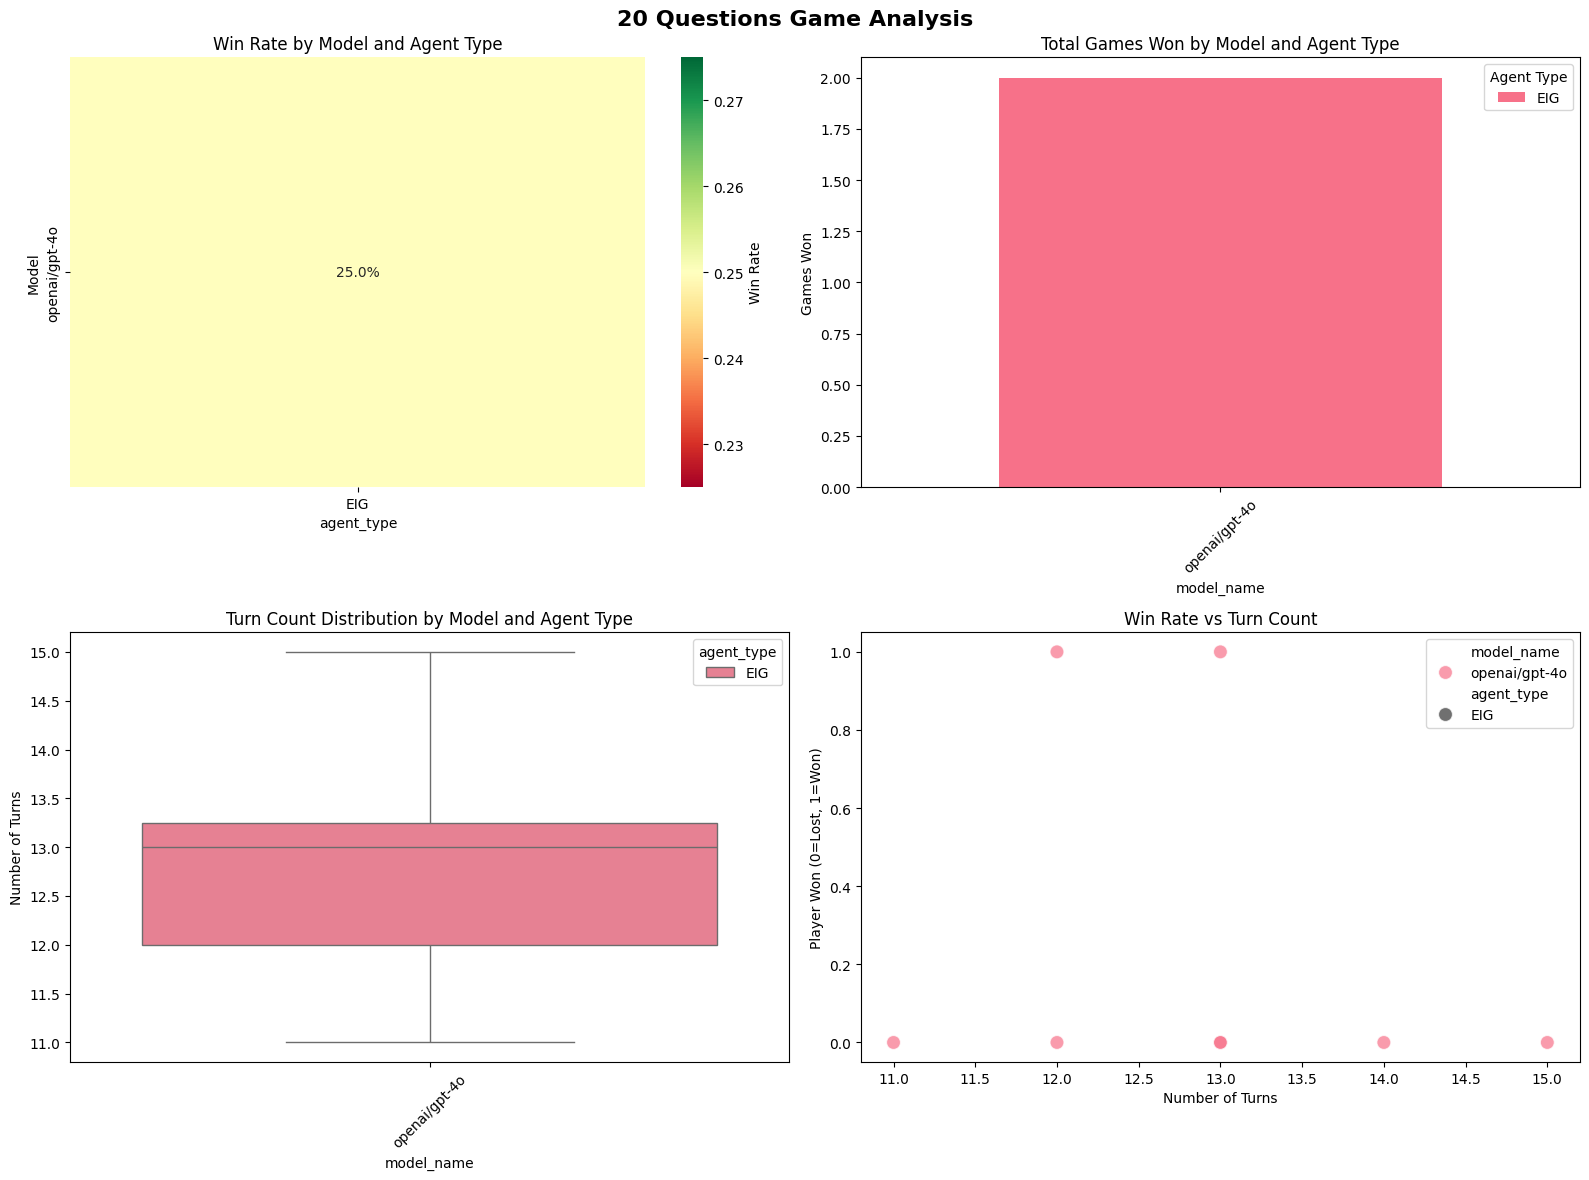


DETAILED STATISTICS

Win Rate Summary:
   model_name agent_type  total_games  games_won  win_rate
openai/gpt-4o        EIG            8          2     0.250

Overall Statistics:
Total Games: 8
Overall Win Rate: 25.0%
Average Turns: 12.9
Average Game Duration: 1692.0s

Model Performance:
              player_won           turn_count game_duration
                   count sum  mean       mean          mean
model_name                                                 
openai/gpt-4o          8   2  0.25     12.875      1692.042

Agent Type Performance:
           player_won           turn_count game_duration
                count sum  mean       mean          mean
agent_type                                              
EIG                 8   2  0.25     12.875      1692.042


In [8]:
if len(df) > 0:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('20 Questions Game Analysis', fontsize=16, fontweight='bold')
    
    # 1. Win Rate by Model and Agent Type
    win_rate_data = df.groupby(['model_name', 'agent_type'])['player_won'].agg(['count', 'sum', 'mean']).reset_index()
    win_rate_data.columns = ['model_name', 'agent_type', 'total_games', 'games_won', 'win_rate']
    
    # Pivot for heatmap
    win_rate_pivot = win_rate_data.pivot(index='model_name', columns='agent_type', values='win_rate')
    
    sns.heatmap(win_rate_pivot, annot=True, fmt='.1%', cmap='RdYlGn', 
                ax=axes[0,0], cbar_kws={'label': 'Win Rate'})
    axes[0,0].set_title('Win Rate by Model and Agent Type')
    axes[0,0].set_ylabel('Model')
    
    # 2. Total Games Won (Bar Chart)
    games_won_pivot = win_rate_data.pivot(index='model_name', columns='agent_type', values='games_won')
    games_won_pivot.plot(kind='bar', ax=axes[0,1], width=0.8)
    axes[0,1].set_title('Total Games Won by Model and Agent Type')
    axes[0,1].set_ylabel('Games Won')
    axes[0,1].legend(title='Agent Type')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Turn Count Distribution
    sns.boxplot(data=df, x='model_name', y='turn_count', hue='agent_type', ax=axes[1,0])
    axes[1,0].set_title('Turn Count Distribution by Model and Agent Type')
    axes[1,0].set_ylabel('Number of Turns')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Win Rate vs Turn Count
    sns.scatterplot(data=df, x='turn_count', y='player_won', 
                   hue='model_name', style='agent_type', 
                   alpha=0.7, s=100, ax=axes[1,1])
    axes[1,1].set_title('Win Rate vs Turn Count')
    axes[1,1].set_ylabel('Player Won (0=Lost, 1=Won)')
    axes[1,1].set_xlabel('Number of Turns')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    
    print("\nWin Rate Summary:")
    print(win_rate_data.to_string(index=False, float_format='%.3f'))
    
    print(f"\nOverall Statistics:")
    print(f"Total Games: {len(df)}")
    print(f"Overall Win Rate: {df['player_won'].mean():.1%}")
    print(f"Average Turns: {df['turn_count'].mean():.1f}")
    print(f"Average Game Duration: {df['game_duration'].mean():.1f}s")
    
    # Model comparison
    print(f"\nModel Performance:")
    model_stats = df.groupby('model_name').agg({
        'player_won': ['count', 'sum', 'mean'],
        'turn_count': 'mean',
        'game_duration': 'mean'
    }).round(3)
    print(model_stats)
    
    # Agent type comparison  
    print(f"\nAgent Type Performance:")
    agent_stats = df.groupby('agent_type').agg({
        'player_won': ['count', 'sum', 'mean'],
        'turn_count': 'mean',
        'game_duration': 'mean'
    }).round(3)
    print(agent_stats)
    
else:
    print("No data available for visualization. Run some experiments first!")

  agent_type  mean  count      ci95
0        EIG  0.25      8  0.300062


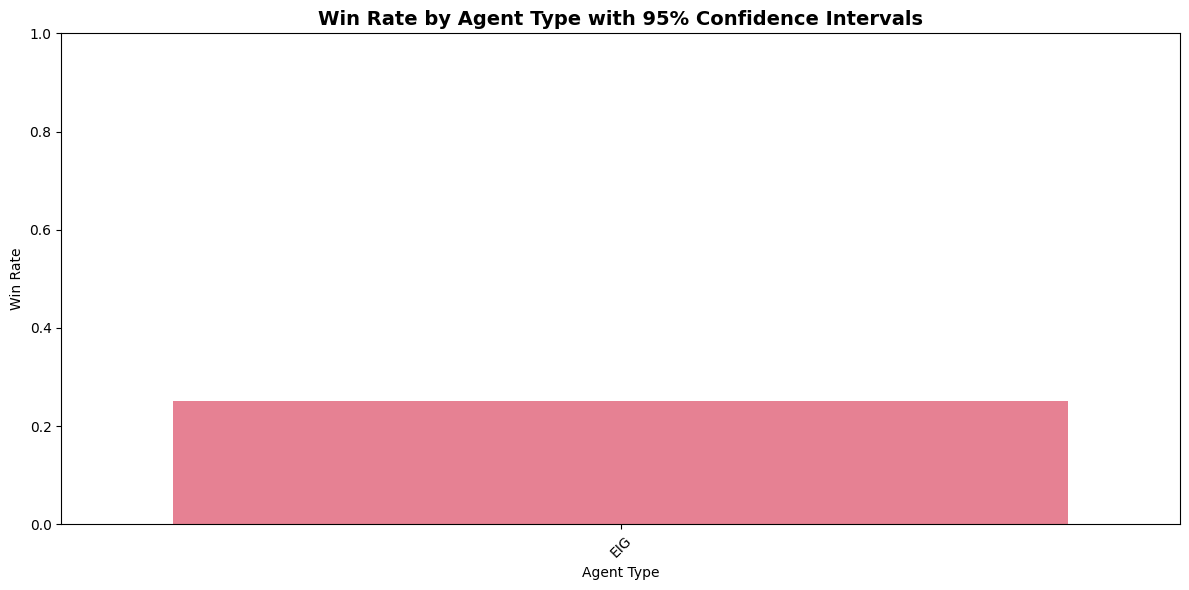

In [9]:
# Additional Analysis: Sample some game results for inspection
if len(df) > 0:
    # Create a bar plot for win rate with 95% confidence intervals
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    win_rate_summary = df.groupby('agent_type')['player_won'].agg(['mean', 'count']).reset_index()
    win_rate_summary['ci95'] = 1.96 * (win_rate_summary['mean'] * (1 - win_rate_summary['mean']) / win_rate_summary['count'])**0.5
    
    print(win_rate_summary)

    sns.barplot(data=win_rate_summary, x='agent_type', y='mean',
                ax=ax, capsize=0.2)
    ax.set_title('Win Rate by Agent Type with 95% Confidence Intervals', fontsize=14, fontweight='bold')
    ax.set_ylabel('Win Rate')
    ax.set_xlabel('Agent Type')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data to display sample results.")
